# Convolutional Neural Network - Char Classification
Using TensorFlow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

%matplotlib notebook
# Increase size of plots
plt.rcParams['figure.figsize'] = (9.0, 5.0)

# Creating CSV
import glob
import csv

# Display Graph
from IPython.display import clear_output, Image, display, HTML

# Helpers
from ocr.datahelpers import loadCharsData, correspondingShuffle
from ocr.helpers import implt
from ocr.mlhelpers import TrainingPlot, DataSet
from ocr.imgtransform import coordinates_remap

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0
Numpy: 1.13.1
TensorFlow: 1.3.0


In [2]:
def sofmaxLabels(lab, clas):
    """ Transform labels for sofmax classification """
    newLab = np.zeros((len(lab), clas), dtype=np.int8)
    for i in range(len(lab)):
        newLab[i][int(lab[i][0])] = 1
    return newLab

### Global Variables

In [3]:
LANG = 'cz'

## Load Images and Lables in CSV

In [4]:
EN_CLAS = 53
CZ_CLAS = 83
CLAS = 53

if LANG == 'en':
    CLAS = EN_CLAS
elif LANG == 'cz':
    CLAS = CZ_CLAS

# dimension 64x64 = 4096
images, labels = loadCharsData(
    charloc='data/charclas/',
    wordloc='data/words/',
    lang=LANG,
    useWords=True)
labels = np.reshape(labels, (len(labels), 1))

images, labels = correspondingShuffle(images, labels)

# Splitting into train and test data
div = int(0.80 * len(images))

# Transform labels for sofmax output
llabels = sofmaxLabels(labels, CLAS)

trainData = images[0:div]
evalData = images[div:]

trainLabels = llabels[0:div]
evalLabels = llabels[div:]

print("Training images: %g" % div)

Loading chars...
Loading words...
-> Number of words: 1008
Loaded chars from words: 4346
-> Number of chars: 6959
Training images: 5567


### Dataset extending

In [5]:
num_new_data = 2
fac_alpha = 1.5
fac_sigma = 0.07

# Dont mix train and test images
trainData_ext = np.zeros((trainData.shape[0] * (num_new_data+1), trainData.shape[1]), dtype=np.float32)
trainLabels_ext = np.zeros((trainLabels.shape[0] * (num_new_data+1), trainLabels.shape[1]), dtype=np.float32)

for idx, img in enumerate(trainData):
    trainData_ext[idx*(num_new_data+1)] = img
    trainLabels_ext[idx*(num_new_data+1)] = trainLabels[idx]
    img = np.reshape(img, (64, 64))
    
    for i in range(num_new_data):
        trainData_ext[idx*(num_new_data+1) + (i+1)] = coordinates_remap(img, fac_alpha, fac_sigma).flatten()
        trainLabels_ext[idx*(num_new_data+1) + (i+1)] = trainLabels[idx]
        
trainData = trainData_ext
trainLabels = trainLabels_ext
print("Transformed train images", len(trainData))

Transformed train images 16701


# Create classifier

### Dataset

In [6]:
# Prepare training dataset
trainSet = DataSet(trainData, trainLabels)

## KNN

In [7]:
with tf.name_scope("KNN") as scope:
    # tf Graph Input
    xtr = tf.placeholder("float", [None, 4096])
    xte = tf.placeholder("float", [4096])

    # Nearest Neighbor calculation using L1 Distance
    # Calculate L1 Distance
    distance = tf.reduce_sum(tf.abs(tf.add(xtr, tf.negative(xte))), reduction_indices=1)
    # Prediction: Get min distance index (Nearest neighbor)
    pred = tf.argmin(distance, 0)

accuracy = 0.

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # loop over test data
    for i in range(len(evalData)):
        # Get nearest neighbor
        nn_index = sess.run(pred, feed_dict={xtr: trainData, xte: evalData[i, :]})
        # Calculate accuracy
        if np.argmax(trainLabels[nn_index]) == np.argmax(evalLabels[i]):
            accuracy += 1./len(evalData)
            
print("Accuracy:", accuracy)

Accuracy: 0.6760057471264255


## Convulation Neural Network

### Graph

In [9]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

# Functions for initializing convulation and pool layers
def conv2d(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def conv2d2(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='SAME', name=name)

def max_pool_2x2(x, name=None):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

def inception2d(x, in_channels, filter_count):
    mu = 0
    sigma = 0.1
    # 1x1
    one_filter = tf.get_variable('one_filter',shape=[1, 1, in_channels, filter_count],
                                 initializer=tf.contrib.layers.xavier_initializer())
    one_bias = tf.Variable(tf.constant(0.2, shape=[filter_count]))
    one_by_one = conv2d(x, one_filter) + one_bias

    # 3x3
    three_filter = tf.get_variable('three_filter', shape=[3, 3, in_channels, filter_count],
                                   initializer=tf.contrib.layers.xavier_initializer())
    three_bias = tf.Variable(tf.constant(0.2, shape=[filter_count]))
    three_by_three = conv2d(x, three_filter) + three_bias

    # 5x5
    five_filter = tf.get_variable('five_filter', shape=[5, 5, in_channels, filter_count],
                                  initializer=tf.contrib.layers.xavier_initializer())
    five_bias = tf.Variable(tf.constant(0.2, shape=[filter_count]))
    five_by_five = conv2d(x, five_filter) + five_bias

    # avg pooling
    pooling = tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')

    x = tf.concat([one_by_one, three_by_three, five_by_five, pooling], axis=3)  # Concat in the 4th dim to stack
    return tf.nn.relu(x)


# Regularization scale - FOR TWEAKING
SCALE = 0.1

# Place holders for data (x) and labels (y_)
x = tf.placeholder(tf.float32, [None, 4096], name='x')
y_ = tf.placeholder(tf.float32, [None, CLAS])

# Reshape data
reshape_images = tf.reshape(x, [-1, 64, 64, 1])

# Image standardization
x_image = tf.map_fn(
    lambda img: tf.image.per_image_standardization(img), reshape_images)


# 1. Layer - Convulation + Subsampling
W_conv1 = tf.get_variable('W_conv1', shape=[16, 16, 1, 4],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv1 = tf.Variable(tf.constant(0.1, shape=[4]), name='b_conv1')

h_conv1 = tf.nn.relu(conv2d2(x_image, W_conv1) + b_conv1, name='h_conv1')    

# 2. Layer - Max Pool
h_pool1 = max_pool_2x2(h_conv1, name='h_pool1')    

# 3. Inception
with tf.variable_scope("inception1") as scope:
    incept1 = inception2d(h_pool1, 4, 12)
    
# 4. Inception
with tf.variable_scope("inception2") as scope:
    incept2 = inception2d(incept1, 40, 20)

# 5. Layer - Max Pool
h_pool3 = max_pool_2x2(incept2)

# Reshape filters into flat arraty
h_flat = tf.reshape(h_pool3, [-1, 8*8*100])

# 6. Dropout
keep_prob = tf.placeholder(tf.float32)
h_flat_drop = tf.nn.dropout(h_flat, keep_prob)

# 9. Output layer
W_fc1 = tf.get_variable('W_fc2', shape=[8*8*100, CLAS],
                        initializer=tf.contrib.layers.xavier_initializer(),
                        regularizer=tf.contrib.layers.l2_regularizer(scale=SCALE))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[CLAS]), name='b_fc2')

y_conv = tf.matmul(h_flat_drop, W_fc1) + b_fc1


# Creating activation function for using the model when imported
activation = tf.argmax(tf.matmul(h_flat, W_fc1) + b_fc1, 1, name='activation')


# Cost: cross entropy + regularization
# Regularization with L2 Regularization with decaying learning rate
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_)
regularization = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
cost = tf.reduce_mean(cross_entropy) + sum(regularization)


# Optimizing model parametrs
train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)


# Measuring accuracy of model
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training

<IPython.core.display.Javascript object>


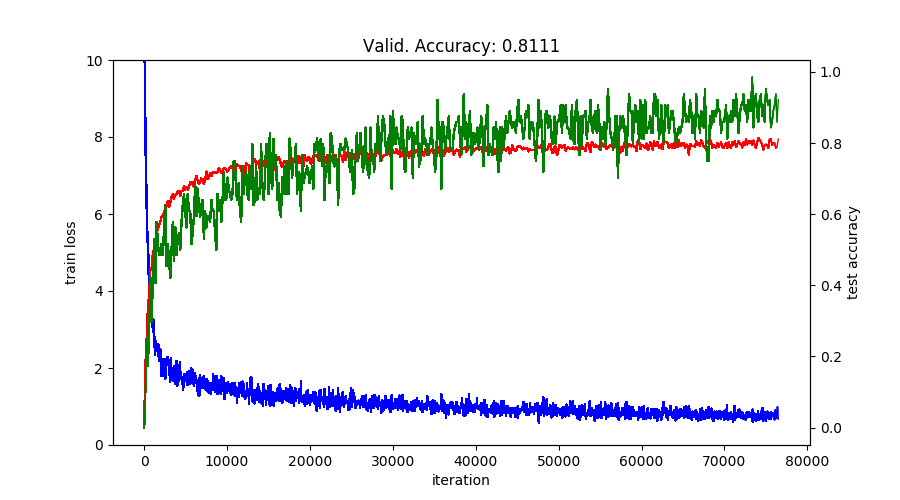

Kernel interrupted, saving model...
Accuracy 0.804598


In [10]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# Set the logs writer to the folder and save graph for Tensorboard
summary_writer = tf.summary.FileWriter('logs', sess.graph)

### SETTINGS  ###
TRAIN_STEPS = 1000000
TEST_ITER = 150
COST_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 64

# Creat plot for live stats ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, COST_ITER)

try:
    for i in range(TRAIN_STEPS):
        trainBatch, labelBatch = trainSet.next_batch(BATCH_SIZE)


        if i%COST_ITER == 0:
            # Plotting cost
            tmpCost = cost.eval(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 1.0})
            trainPlot.updateCost(tmpCost, i // COST_ITER)

        if i%TEST_ITER == 0:
            # Plotting accuracy
            accEval = accuracy.eval(feed_dict={x: evalData, y_: evalLabels, keep_prob: 1.0})
            accTrain = accuracy.eval(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 1.0})
            trainPlot.updateAcc(accEval, accTrain, i // TEST_ITER)

        if i%SAVE_ITER == 0:
            saver.save(sess, 'models/char-clas/' + LANG + '/CharClassifier')

        train_step.run(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 0.4})
        
except KeyboardInterrupt:
    print("Kernel interrupted, saving model...")

    
# Final Save
saver.save(sess, 'models/char-clas/' + LANG + '/CharClassifier')

print("Accuracy %g" % accuracy.eval(feed_dict={x: evalData, y_: evalLabels, keep_prob: 1.0}))